In [15]:
import pandas as pd
import numpy as np

In [17]:
df = pd.read_csv("E:\\J P Morgan Quantitative Research\\Task4.csv")
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [19]:
from sklearn.cluster import KMeans

K = 5  # num of buckets
kmeans = KMeans(n_clusters=K, random_state=42)
df['fico_bucket'] = kmeans.fit_predict(df[['fico_score']])


In [21]:
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,fico_bucket
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,0
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,1
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,2
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,1


In [23]:
# Assign mean FICO score to each cluster
cluster_means = df.groupby('fico_bucket')['fico_score'].mean().sort_values().reset_index()

# Create a mapping from KMeans labels to ordered risk buckets (0 = best credit, 4 = worst)
bucket_mapping = {old: new for new, old in enumerate(cluster_means['fico_bucket'])}

# Apply mapping
df['fico_bucket'] = df['fico_bucket'].map(bucket_mapping)


In [25]:
bucket_summary = (
    df.groupby('fico_bucket')['default']
    .agg(['count', 'sum'])
    .rename(columns={'count': 'Total_Borrowers', 'sum': 'Defaults'})
)

bucket_summary['PD (%)'] = (bucket_summary['Defaults'] / bucket_summary['Total_Borrowers']) * 100
bucket_summary = bucket_summary.round(2).reset_index()
print(bucket_summary)


   fico_bucket  Total_Borrowers  Defaults  PD (%)
0            0             1080       516   47.78
1            1             2569       658   25.61
2            2             3036       447   14.72
3            3             2353       197    8.37
4            4              962        33    3.43


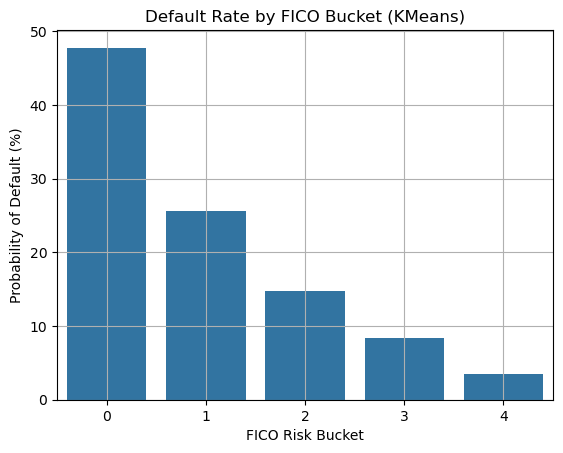

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=bucket_summary, x='fico_bucket', y='PD (%)')
plt.title("Default Rate by FICO Bucket (KMeans)")
plt.xlabel("FICO Risk Bucket")
plt.ylabel("Probability of Default (%)")
plt.grid(True)
plt.show()


## 📊 Interpretation: Default Rate by KMeans-Based FICO Buckets

The table below shows the results of segmenting FICO scores using unsupervised clustering (KMeans with 5 clusters):

| FICO Bucket | Total Borrowers | Defaults | PD (%) |
|-------------|------------------|----------|--------|
| 0 (Lowest FICO Cluster) | 1080             | 516      | 47.78% |
| 1                         | 2569             | 658      | 25.61% |
| 2                         | 3036             | 447      | 14.72% |
| 3                         | 2353             | 197      | 8.37%  |
| 4 (Highest FICO Cluster)  | 962              | 33       | 3.43%  |

### 🔍 Key Observations:
- The KMeans method produced **risk-aligned buckets**, with default probabilities decreasing as credit quality improves.
- **Bucket 0**, representing the **most risky segment**, has an extremely high PD of nearly **48%**.
- **Bucket 4**, the least risky, shows a **very low PD of 3.43%**.
- Unlike quantile binning, KMeans produced **uneven bucket sizes**, which may reflect real-world credit score distributions more accurately.

### ✅ Conclusion:
KMeans clustering effectively captures non-linear relationships between FICO scores and default risk. Though the buckets vary in size, they reflect meaningful credit risk tiers and are suitable for use in credit scoring models that benefit from data-driven binning.
